# MLP 203
* Operate on 16000 GenCode 34 seqs.
* 5-way cross validation. Save best model per CV.
* Report mean accuracy from final re-validation with best 5.
* Use Adam with a learn rate decay schdule.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP203'
NEURONS=16

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [3]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [4]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [5]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [6]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [8]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [9]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: MLP203.model/assets
Data prep
Data reshape


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 3s 6ms/step - loss: 0.5606 - accuracy: 0.7097 - val_loss: 0.5260 - val_accuracy: 0.7343
Epoch 2/200
453/453 [==============================] - 3s 6ms/step - loss: 0.5499 - accuracy: 0.7148 - val_loss: 0.5230 - val_accuracy: 0.7387
Epoch 3/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5433 - accuracy: 0.7185 - val_loss: 0.5345 - val_accuracy: 0.7337
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5446 - accuracy: 0.7221 - val_loss: 0.5359 - val_accuracy: 0.7306
Epoch 5/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5440 - accuracy: 0.7208 - val_loss: 0.5540 - val_accuracy: 0.7157
Epoch 6/200
453/453 [==============================] - 3s 6ms/step - loss: 0.5431 - accuracy: 0.7208 - val_loss: 0.5234 - val_accuracy: 0.7362
Epoch 7/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5413 - accuracy: 0.719

Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5325 - accuracy: 0.7281 - val_loss: 0.5289 - val_accuracy: 0.7381
Epoch 55/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5338 - accuracy: 0.7287 - val_loss: 0.5273 - val_accuracy: 0.7337
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5336 - accuracy: 0.7295 - val_loss: 0.5259 - val_accuracy: 0.7393
Epoch 57/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5329 - accuracy: 0.7284 - val_loss: 0.5245 - val_accuracy: 0.7356
Epoch 58/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5331 - accuracy: 0.7312 - val_loss: 0.5240 - val_accuracy: 0.7318
Epoch 59/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5329 - accuracy: 0.7292 - val_loss: 0.5387 - val_accuracy: 0.7337
Epoch 60/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5332 - accuracy: 0.7279 - val_loss: 0.5214 - val_accuracy:

Epoch 109/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5293 - accuracy: 0.7316 - val_loss: 0.5221 - val_accuracy: 0.7436
Epoch 110/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5303 - accuracy: 0.7317 - val_loss: 0.5203 - val_accuracy: 0.7424
Epoch 111/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5288 - accuracy: 0.7326 - val_loss: 0.5269 - val_accuracy: 0.7331
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5307 - accuracy: 0.7287 - val_loss: 0.5221 - val_accuracy: 0.7449
Epoch 113/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5294 - accuracy: 0.7299 - val_loss: 0.5282 - val_accuracy: 0.7430
Epoch 114/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5293 - accuracy: 0.7310 - val_loss: 0.5223 - val_accuracy: 0.7399
Epoch 115/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5300 - accuracy: 0.7348 - val_loss: 0.5285 - val_ac

453/453 [==============================] - 1s 3ms/step - loss: 0.5255 - accuracy: 0.7328 - val_loss: 0.5147 - val_accuracy: 0.7498
Epoch 162/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5267 - accuracy: 0.7348 - val_loss: 0.5209 - val_accuracy: 0.7430
Epoch 163/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5260 - accuracy: 0.7328 - val_loss: 0.5165 - val_accuracy: 0.7480
Epoch 164/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5259 - accuracy: 0.7342 - val_loss: 0.5158 - val_accuracy: 0.7368
Epoch 165/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5255 - accuracy: 0.7337 - val_loss: 0.5148 - val_accuracy: 0.7455
Epoch 166/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5271 - accuracy: 0.7340 - val_loss: 0.5147 - val_accuracy: 0.7486
Epoch 167/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5258 - accuracy: 0.7357 - val_loss: 0.5185 - val_accuracy: 0.7449

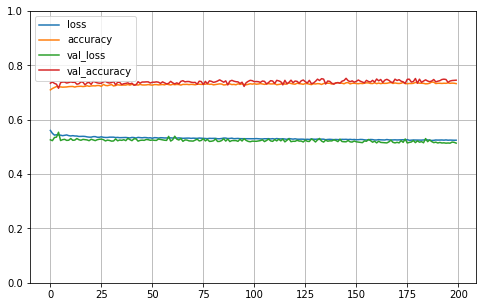

accuracy: 75.23%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 4s 8ms/step - loss: 0.5589 - accuracy: 0.7125 - val_loss: 0.5655 - val_accuracy: 0.7132
Epoch 2/200
453/453 [==============================] - 3s 6ms/step - loss: 0.5437 - accuracy: 0.7208 - val_loss: 0.5459 - val_accuracy: 0.7219
Epoch 3/200
453/453 [==============================] - 3s 7ms/step - loss: 0.5430 - accuracy: 0.7209 - val_loss: 0.5464 - val_accuracy: 0.7306
Epoch 4/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5445 - accuracy: 0.7202 - val_loss: 0.5467 - val_accuracy: 0.7306
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5415 - accuracy: 0.7232 - val_loss: 0.5433 - val_accuracy: 0.7294
Epoch 6/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5405 - accuracy: 0.7256 - val_loss: 0.5425 - val_accuracy: 0.7318
Epoch 7/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5384 - accuracy: 0.72

453/453 [==============================] - 1s 2ms/step - loss: 0.5314 - accuracy: 0.7272 - val_loss: 0.5447 - val_accuracy: 0.7281
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5321 - accuracy: 0.7286 - val_loss: 0.5376 - val_accuracy: 0.7343
Epoch 52/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5322 - accuracy: 0.7279 - val_loss: 0.5355 - val_accuracy: 0.7424
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5310 - accuracy: 0.7279 - val_loss: 0.5524 - val_accuracy: 0.7244
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5305 - accuracy: 0.7301 - val_loss: 0.5366 - val_accuracy: 0.7306
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5310 - accuracy: 0.7275 - val_loss: 0.5402 - val_accuracy: 0.7349
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5303 - accuracy: 0.7291 - val_loss: 0.5370 - val_accuracy: 0.7343
Epoch

Epoch 106/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5270 - accuracy: 0.7271 - val_loss: 0.5392 - val_accuracy: 0.7443
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5289 - accuracy: 0.7306 - val_loss: 0.5363 - val_accuracy: 0.7287
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5280 - accuracy: 0.7305 - val_loss: 0.5318 - val_accuracy: 0.7405
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5274 - accuracy: 0.7305 - val_loss: 0.5358 - val_accuracy: 0.7362
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5290 - accuracy: 0.7324 - val_loss: 0.5332 - val_accuracy: 0.7436
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5280 - accuracy: 0.7323 - val_loss: 0.5345 - val_accuracy: 0.7399
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5268 - accuracy: 0.7325 - val_loss: 0.5334 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.5254 - accuracy: 0.7325 - val_loss: 0.5325 - val_accuracy: 0.7443
Epoch 160/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5245 - accuracy: 0.7356 - val_loss: 0.5340 - val_accuracy: 0.7393
Epoch 161/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5261 - accuracy: 0.7344 - val_loss: 0.5353 - val_accuracy: 0.7374
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5238 - accuracy: 0.7364 - val_loss: 0.5317 - val_accuracy: 0.7455
Epoch 163/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5248 - accuracy: 0.7329 - val_loss: 0.5366 - val_accuracy: 0.7405
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5245 - accuracy: 0.7348 - val_loss: 0.5334 - val_accuracy: 0.7443
Epoch 165/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5249 - accuracy: 0.7326 - val_loss: 0.5362 - val_accuracy: 0.7405

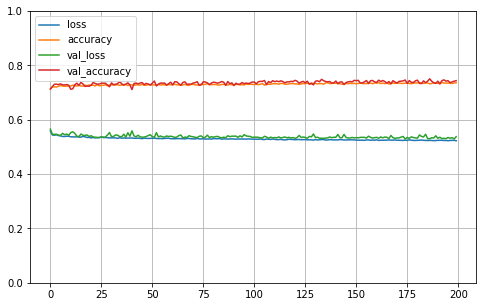

accuracy: 75.05%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5647 - accuracy: 0.7050 - val_loss: 0.5366 - val_accuracy: 0.7300
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5491 - accuracy: 0.7166 - val_loss: 0.5463 - val_accuracy: 0.7250
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5434 - accuracy: 0.7224 - val_loss: 0.5339 - val_accuracy: 0.7343
Epoch 4/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5447 - accuracy: 0.7224 - val_loss: 0.5392 - val_accuracy: 0.7349
Epoch 5/200
453/453 [==============================] - 2s 5ms/step - loss: 0.5424 - accuracy: 0.7207 - val_loss: 0.5384 - val_accuracy: 0.7368
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5429 - accuracy: 0.7226 - val_loss: 0.5319 - val_accuracy: 0.7263
Epoch 7/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5414 - accuracy: 0.71

Epoch 50/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5312 - accuracy: 0.7299 - val_loss: 0.5261 - val_accuracy: 0.7443
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5318 - accuracy: 0.7311 - val_loss: 0.5298 - val_accuracy: 0.7287
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5318 - accuracy: 0.7289 - val_loss: 0.5316 - val_accuracy: 0.7306
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5306 - accuracy: 0.7303 - val_loss: 0.5267 - val_accuracy: 0.7269
Epoch 54/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5307 - accuracy: 0.7302 - val_loss: 0.5235 - val_accuracy: 0.7356
Epoch 55/200
453/453 [==============================] - 2s 4ms/step - loss: 0.5325 - accuracy: 0.7291 - val_loss: 0.5260 - val_accuracy: 0.7368
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5304 - accuracy: 0.7288 - val_loss: 0.5286 - val_accuracy:

453/453 [==============================] - 1s 2ms/step - loss: 0.5278 - accuracy: 0.7331 - val_loss: 0.5222 - val_accuracy: 0.7430
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5261 - accuracy: 0.7364 - val_loss: 0.5246 - val_accuracy: 0.7337
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5273 - accuracy: 0.7301 - val_loss: 0.5287 - val_accuracy: 0.7405
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5262 - accuracy: 0.7353 - val_loss: 0.5349 - val_accuracy: 0.7318
Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5270 - accuracy: 0.7352 - val_loss: 0.5290 - val_accuracy: 0.7356
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5280 - accuracy: 0.7347 - val_loss: 0.5251 - val_accuracy: 0.7436
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5257 - accuracy: 0.7358 - val_loss: 0.5228 - val_accuracy: 0.7368

453/453 [==============================] - 1s 2ms/step - loss: 0.5248 - accuracy: 0.7326 - val_loss: 0.5238 - val_accuracy: 0.7337
Epoch 159/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5241 - accuracy: 0.7350 - val_loss: 0.5243 - val_accuracy: 0.7399
Epoch 160/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5251 - accuracy: 0.7347 - val_loss: 0.5269 - val_accuracy: 0.7337
Epoch 161/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5250 - accuracy: 0.7352 - val_loss: 0.5243 - val_accuracy: 0.7356
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5251 - accuracy: 0.7342 - val_loss: 0.5229 - val_accuracy: 0.7405
Epoch 163/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5237 - accuracy: 0.7329 - val_loss: 0.5249 - val_accuracy: 0.7387
Epoch 164/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.7373 - val_loss: 0.5211 - val_accuracy: 0.7374

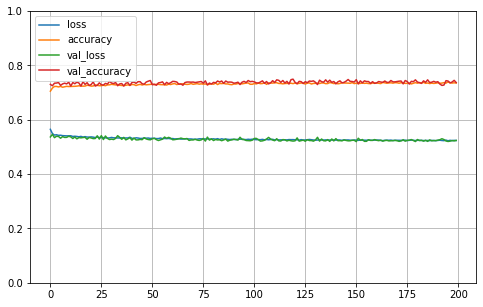

accuracy: 74.92%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5594 - accuracy: 0.7118 - val_loss: 0.5332 - val_accuracy: 0.7287
Epoch 2/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5484 - accuracy: 0.7206 - val_loss: 0.5461 - val_accuracy: 0.7349
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5443 - accuracy: 0.7198 - val_loss: 0.5318 - val_accuracy: 0.7349
Epoch 4/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5422 - accuracy: 0.7219 - val_loss: 0.5286 - val_accuracy: 0.7232
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5426 - accuracy: 0.7209 - val_loss: 0.5277 - val_accuracy: 0.7362
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5415 - accuracy: 0.7206 - val_loss: 0.5364 - val_accuracy: 0.7331
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5412 - accuracy: 0.72

Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5281 - accuracy: 0.7323 - val_loss: 0.5255 - val_accuracy: 0.7318
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5300 - accuracy: 0.7323 - val_loss: 0.5209 - val_accuracy: 0.7349
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5289 - accuracy: 0.7303 - val_loss: 0.5182 - val_accuracy: 0.7374
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5292 - accuracy: 0.7330 - val_loss: 0.5176 - val_accuracy: 0.7393
Epoch 57/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5281 - accuracy: 0.7325 - val_loss: 0.5184 - val_accuracy: 0.7424
Epoch 58/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5283 - accuracy: 0.7344 - val_loss: 0.5191 - val_accuracy: 0.7412
Epoch 59/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5273 - accuracy: 0.7319 - val_loss: 0.5213 - val_accuracy:

Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5237 - accuracy: 0.7372 - val_loss: 0.5205 - val_accuracy: 0.7405
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5250 - accuracy: 0.7341 - val_loss: 0.5264 - val_accuracy: 0.7381
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5240 - accuracy: 0.7363 - val_loss: 0.5291 - val_accuracy: 0.7362
Epoch 113/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5248 - accuracy: 0.7330 - val_loss: 0.5194 - val_accuracy: 0.7387
Epoch 114/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5237 - accuracy: 0.7357 - val_loss: 0.5185 - val_accuracy: 0.7405
Epoch 115/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5248 - accuracy: 0.7357 - val_loss: 0.5246 - val_accuracy: 0.7306
Epoch 116/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5239 - accuracy: 0.7379 - val_loss: 0.5310 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.5230 - accuracy: 0.7390 - val_loss: 0.5209 - val_accuracy: 0.7387
Epoch 165/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5226 - accuracy: 0.7364 - val_loss: 0.5210 - val_accuracy: 0.7412
Epoch 166/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.7376 - val_loss: 0.5206 - val_accuracy: 0.7374
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5236 - accuracy: 0.7373 - val_loss: 0.5240 - val_accuracy: 0.7374
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5224 - accuracy: 0.7376 - val_loss: 0.5268 - val_accuracy: 0.7356
Epoch 169/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5232 - accuracy: 0.7360 - val_loss: 0.5248 - val_accuracy: 0.7374
Epoch 170/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5220 - accuracy: 0.7411 - val_loss: 0.5188 - val_accuracy: 0.7368

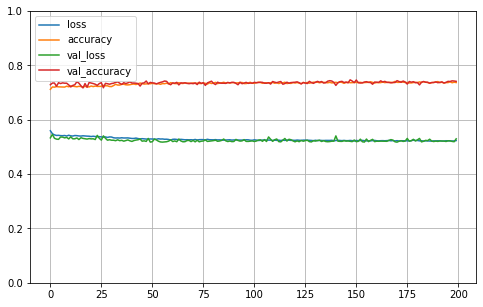

accuracy: 74.67%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5562 - accuracy: 0.7125 - val_loss: 0.5666 - val_accuracy: 0.7033
Epoch 2/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5451 - accuracy: 0.7215 - val_loss: 0.5366 - val_accuracy: 0.7294
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5427 - accuracy: 0.7205 - val_loss: 0.5351 - val_accuracy: 0.7306
Epoch 4/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5450 - accuracy: 0.7208 - val_loss: 0.5316 - val_accuracy: 0.7337
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.5426 - accuracy: 0.7197 - val_loss: 0.5351 - val_accuracy: 0.7362
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5440 - accuracy: 0.7213 - val_loss: 0.5306 - val_accuracy: 0.7325
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5422 - accuracy: 0.72

453/453 [==============================] - 1s 3ms/step - loss: 0.5343 - accuracy: 0.7269 - val_loss: 0.5222 - val_accuracy: 0.7467
Epoch 48/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5347 - accuracy: 0.7266 - val_loss: 0.5289 - val_accuracy: 0.7412
Epoch 49/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5340 - accuracy: 0.7274 - val_loss: 0.5240 - val_accuracy: 0.7300
Epoch 50/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5330 - accuracy: 0.7275 - val_loss: 0.5288 - val_accuracy: 0.7387
Epoch 51/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5335 - accuracy: 0.7273 - val_loss: 0.5201 - val_accuracy: 0.7412
Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5353 - accuracy: 0.7261 - val_loss: 0.5215 - val_accuracy: 0.7418
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5332 - accuracy: 0.7263 - val_loss: 0.5215 - val_accuracy: 0.7436
Epoch

Epoch 102/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5274 - accuracy: 0.7306 - val_loss: 0.5173 - val_accuracy: 0.7455
Epoch 103/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5289 - accuracy: 0.7321 - val_loss: 0.5197 - val_accuracy: 0.7430
Epoch 104/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5292 - accuracy: 0.7298 - val_loss: 0.5172 - val_accuracy: 0.7498
Epoch 105/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5274 - accuracy: 0.7309 - val_loss: 0.5175 - val_accuracy: 0.7474
Epoch 106/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5291 - accuracy: 0.7332 - val_loss: 0.5253 - val_accuracy: 0.7474
Epoch 107/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5282 - accuracy: 0.7304 - val_loss: 0.5164 - val_accuracy: 0.7492
Epoch 108/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5282 - accuracy: 0.7323 - val_loss: 0.5252 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.5257 - accuracy: 0.7308 - val_loss: 0.5126 - val_accuracy: 0.7486
Epoch 157/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5258 - accuracy: 0.7350 - val_loss: 0.5122 - val_accuracy: 0.7449
Epoch 158/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5257 - accuracy: 0.7303 - val_loss: 0.5174 - val_accuracy: 0.7455
Epoch 159/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5254 - accuracy: 0.7324 - val_loss: 0.5127 - val_accuracy: 0.7424
Epoch 160/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5258 - accuracy: 0.7338 - val_loss: 0.5142 - val_accuracy: 0.7492
Epoch 161/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5255 - accuracy: 0.7333 - val_loss: 0.5134 - val_accuracy: 0.7430
Epoch 162/200
453/453 [==============================] - 1s 2ms/step - loss: 0.5251 - accuracy: 0.7349 - val_loss: 0.5139 - val_accuracy: 0.7480

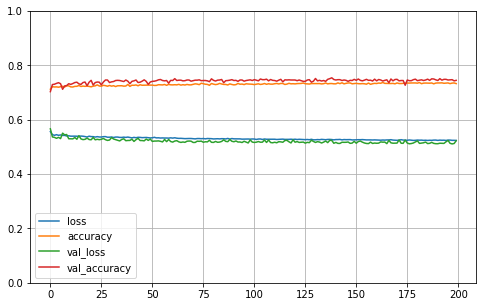

accuracy: 75.42%

5-way Cross Validation mean 75.06% (+/- 0.26%)
Done


In [10]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")